In [21]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
import os

seed = 7
tf.random.set_seed(seed)

In [2]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()

In [3]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global x_scaler
    global y_scaler
    
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    # scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [4]:
class RandomizedNetwork(keras.Model):
    
    def __init__(self, input_size, output_size, layers, init=None, reg=None):
        super().__init__()
        
        if init is None:
            init = initializers.RandomNormal(mean=0, stddev=1, seed=None)
        
        self.reg = reg
        
        self.model = Sequential()
                    
            
        units = layers[0]["units"]
        activation = layers[0]["activation"]
        self.model.add(Dense(units, input_dim=input_size, activation=activation,
                    kernel_initializer = init, bias_initializer = init))
        self.model.layers[0].trainable = False
        
        
        
        for layer in layers[1:]:
            activation = layer["activation"]
            units = layer["units"]
            self.model.add(Dense(units, activation=activation, 
                        kernel_initializer = init, bias_initializer = init))
            self.model.layers[-1].trainable = False
        
        self.model.add(Dense(output_size, activation="linear",
                    kernel_initializer = init, bias_initializer = init))
        
        
        self.compile(loss="mse", metrics = mee)
        
        
        
                
    def lms_solve(self, x, y):
        
        n = x.shape[0]
        
        # x_b = np.append(x, np.ones((n,1)), axis=-1)
        for layer in self.model.layers[:-1]:
            x = layer(x)
        
        H = x.numpy()
        H = np.append(H, np.ones((n,1)), axis=-1)
        # H = self.model.layers[0](x).numpy()
        
        # if regularization is used apply direct solution
        if self.reg is not None:
            H_t = H.transpose()
            H = np.matmul(H_t, H)
            I = np.identity(H.shape[0])
            H = H + self.reg*I
            H_star = np.linalg.inv(H)
            W = np.matmul(H_star, H_t)
            W = np.matmul(W, y)
        # if regularization is not used apply numpy LMS solver
        else:
            W, _, _, _ = np.linalg.lstsq(H.T.dot(H), H.T.dot(y))
            
        b = W[-1:][0]
        W = W[:-1]
        
        # print(W.shape)
        # print(b.shape)
        # print(self.model.layers[-1].get_weights()[0].shape)
        # print(self.model.layers[-1].get_weights()[1].shape)
        self.model.layers[-1].set_weights([W, b])

        
    def call(self, x):
        return self.model(x)
    
    def summary(self):
        self.model.summary()
        

In [5]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def mee(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1)))
    
    
def mse(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1))

def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("initialization")
    keys.remove("trials_train")
    keys.remove("trials_test")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        
        configurations.append(dict_conf)
        
        
    return configurations


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

    

def get_model(config, input_size, output_size):
    
    init_method = config["initialization"]["type"]
    reg = config["regularization"]
        
    init = None
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    if init_method == "normal":
        mean = config["initialization"]["mean"]
        std = config["initialization"]["std"]
        init = initializers.RandomNormal(mean=mean, stddev=std, seed=None)
        
        
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1
    
    layers = []
    for l in range(1, n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        layers.append({ 
            "activation": activation,
            "units": n_units
        })
        
    model = RandomizedNetwork(input_size, output_size, layers, init, reg)
        
    return model
    
    

def get_metrics(model, x_train, y_train, x_test=None, y_test=None):
    train_loss, train_metric  = model.evaluate(x_train, y_train, verbose=0)
    test_loss, test_metric  = model.evaluate(x_test, y_test, verbose=0) if x_test is not None else [None, None]
    return train_loss, train_metric, test_loss, test_metric
    

def fit_model_k_fold(x_train, y_train, config, n_folds):
    

    train_metric = "mee"
    val_metric = "val_mee"

    trials = config["trials_train"]

    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                model = get_model(config, input_size, output_size)
                
                model.lms_solve(x_train_fold, y_train_fold)
                
                trial_train_loss, trial_train_acc, trial_val_loss, trial_val_acc = get_metrics(model, x_train_fold, y_train_fold, x_val_fold, y_val_fold)

                trials_val_loss.append(trial_val_loss)
                trials_train_loss.append(trial_train_loss)
                trials_val_acc.append(trial_val_acc)
                trials_train_acc.append(trial_train_acc)

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    train_metric = "mee"
    val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
                
            model.lms_solve(x_train, y_train)

            trial_train_loss, trial_train_acc, trial_val_loss, trial_val_acc = get_metrics(model, x_train, y_train, x_val, y_val)

            trials_val_loss.append(trial_val_loss)
            trials_train_loss.append(trial_train_loss)
            trials_val_acc.append(trial_val_acc)
            trials_train_acc.append(trial_train_acc)
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"Median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    
def fit_final_model(x_train, y_train, config):

    train_metric = "mee"
    val_metric = "val_mee"
    train_loss = "mse"
    val_loss = "mse"

    trials = config["trials_test"]

            
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    
    models = []
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=None)

    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            model = get_model(config, input_size, output_size)
                
            model.lms_solve(x_train, y_train)
            
            models.append(model)

            trial_train_loss, trial_train_acc, trial_val_loss, trial_val_acc = get_metrics(model, x_train, y_train, x_val, y_val)

            trials_val_loss.append(trial_val_loss)
            trials_train_loss.append(trial_train_loss)
            trials_val_acc.append(trial_val_acc)
            trials_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc}")

            pbar.update(1)
        
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric} {std_train_acc}")
        
    med_model = models[med_idx]
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss


def assess_model(model, x_train, y_train, x_test, y_test, scale=True):
    global y_scaler
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    if scale: 
        y_train_pred = y_scaler.inverse_transform(y_train_pred)
        y_train = y_scaler.inverse_transform(y_train)
        y_test_pred = y_scaler.inverse_transform(y_test_pred)
        y_test = y_scaler.inverse_transform(y_test)
    
    
    mse_train = mse(y_train, y_train_pred)
    mse_test = mse(y_test, y_test_pred)
    
    mee_train = mee(y_train, y_train_pred)
    mee_test = mee(y_test, y_test_pred)
    
    print(f"Train MSE: {mse_train}")
    print(f"Train MEE: {mee_train}")
    print(f"Test MSE: {mse_test}")
    print(f"Test MSE: {mee_test}")
    
    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}):
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, best_conf)
    
    return model

In [6]:
normal = {
    "type": "normal",
    "mean": 0,
    "std": 0.5
}

unif = {
    "type": "uniform",
    "min": -1,
    "max": 1
}

params = {
    "trials_train": 10,
    "trials_test": 10,
    "initialization": normal,
    "regularization": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    "layers": [
        {
            "activations": ["tanh"],
            "units": [10, 100, 500, 1000],
        }
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.2
}


# ML Cup

In [7]:
x_train, y_train, x_test, y_test = load_dataset("cup", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1343, 9) (1343, 2)
(149, 9) (149, 2)


In [8]:
model = grid_search(params, x_train, y_train, hold_out_val)
assess_model(model, x_train, y_train, x_test, y_test, True)

Testing configuration 1/36:
{'regularization': 0.0001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 10}


  0%|                                                    | 0/10 [00:00<?, ?it/s]2022-12-22 09:32:24.356900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 09:32:24.424306: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-12-22 09:32:24.424328: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-22 09:32:24.424713: I tensorflow/core/platform/cpu_feature_guard.cc:193] Thi

Median val_loss: 0.1796623319387436, std val_loss 0.02059504541672131
Median train_loss: 0.1721034049987793, std train_loss 0.02342282460118602
Median val_mee: 0.5261144042015076, std val_mee 0.03220428108156163
Median train_mee: 0.5042650103569031, train_mee 0.034429669703798245



Testing configuration 2/36:
{'regularization': 0.0001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 100}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.44it/s]


Median val_loss: 0.08819663524627686, std val_loss 0.00295557303531681
Median train_loss: 0.07978007942438126, std train_loss 0.001046273119211592
Median val_mee: 0.3215924799442291, std val_mee 0.009362235383240249
Median train_mee: 0.3158986568450928, train_mee 0.0038742647701142992



Testing configuration 3/36:
{'regularization': 0.0001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.99it/s]


Median val_loss: 0.13531795144081116, std val_loss 0.012134687716985969
Median train_loss: 0.04485486447811127, std train_loss 0.0009502366892338877
Median val_mee: 0.4222503900527954, std val_mee 0.017387432288198914
Median train_mee: 0.23167915642261505, train_mee 0.002548220677771568



Testing configuration 4/36:
{'regularization': 0.0001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.36it/s]


Median val_loss: 3.6342971324920654, std val_loss 0.22474343113463963
Median train_loss: 0.006769323255866766, std train_loss 0.0005400660893245707
Median val_mee: 1.9078691005706787, std val_mee 0.06407657391390666
Median train_mee: 0.08164878189563751, train_mee 0.0031601643892604555



Testing configuration 5/36:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 10}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Median val_loss: 0.16338622570037842, std val_loss 0.014879182004760853
Median train_loss: 0.1623155176639557, std train_loss 0.009841249965726979
Median val_mee: 0.48286929726600647, std val_mee 0.022488423221553512
Median train_mee: 0.47906938195228577, train_mee 0.015157158918580754



Testing configuration 6/36:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 100}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.09it/s]


Median val_loss: 0.08969739824533463, std val_loss 0.001067918127954692
Median train_loss: 0.07738659530878067, std train_loss 0.002032060999519141
Median val_mee: 0.344013512134552, std val_mee 0.003075507019375737
Median train_mee: 0.30721789598464966, train_mee 0.004286805897605372



Testing configuration 7/36:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.98it/s]


Median val_loss: 0.15976035594940186, std val_loss 0.010807983759513905
Median train_loss: 0.04595530405640602, std train_loss 0.0006566887337084198
Median val_mee: 0.4415029287338257, std val_mee 0.01179990865428176
Median train_mee: 0.23474285006523132, train_mee 0.0026396491932700163



Testing configuration 8/36:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}


100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.22it/s]


Median val_loss: 1.5117970705032349, std val_loss 0.21637407676886466
Median train_loss: 0.008464792743325233, std train_loss 0.0005368056926742769
Median val_mee: 1.3297123908996582, std val_mee 0.05992498542295908
Median train_mee: 0.09091275930404663, train_mee 0.003454967290316564



Testing configuration 9/36:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 10}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.29it/s]


Median val_loss: 0.20478582382202148, std val_loss 0.0220628569952819
Median train_loss: 0.15622343122959137, std train_loss 0.01936283780561655
Median val_mee: 0.5446349382400513, std val_mee 0.03524879749984921
Median train_mee: 0.4835846424102783, train_mee 0.02656801565752632



Testing configuration 10/36:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 100}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.33it/s]


Median val_loss: 0.08405611664056778, std val_loss 0.002641187149015687
Median train_loss: 0.07960960268974304, std train_loss 0.0017854515662480163
Median val_mee: 0.3315337896347046, std val_mee 0.005418105648696154
Median train_mee: 0.31258848309516907, train_mee 0.0046477801800372896



Testing configuration 11/36:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.31it/s]


Median val_loss: 0.15164422988891602, std val_loss 0.010561377253552643
Median train_loss: 0.040668778121471405, std train_loss 0.0010344201510233823
Median val_mee: 0.45075660943984985, std val_mee 0.009885407425337368
Median train_mee: 0.22479155659675598, train_mee 0.0029086050618053784



Testing configuration 12/36:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]


Median val_loss: 0.4166070222854614, std val_loss 0.04810549855736261
Median train_loss: 0.017488516867160797, std train_loss 0.0009922856473427984
Median val_mee: 0.708871603012085, std val_mee 0.023610549841316688
Median train_mee: 0.13263657689094543, train_mee 0.0035099459879299184



Testing configuration 13/36:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 10}


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.58it/s]


Median val_loss: 0.16480877995491028, std val_loss 0.019676914200695103
Median train_loss: 0.17962637543678284, std train_loss 0.0193137535616758
Median val_mee: 0.49230247735977173, std val_mee 0.03391976815467597
Median train_mee: 0.5088567733764648, train_mee 0.033980014008007875



Testing configuration 14/36:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 100}


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.52it/s]


Median val_loss: 0.08584889769554138, std val_loss 0.0030069448855331382
Median train_loss: 0.07847214490175247, std train_loss 0.0010656116504189897
Median val_mee: 0.3349234461784363, std val_mee 0.008284029048654828
Median train_mee: 0.3055632412433624, train_mee 0.0036938150190788054



Testing configuration 15/36:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.02it/s]


Median val_loss: 0.11424478143453598, std val_loss 0.005860226918951165
Median train_loss: 0.04533180966973305, std train_loss 0.0008452174382459043
Median val_mee: 0.3985777795314789, std val_mee 0.010775065615666223
Median train_mee: 0.2303631752729416, train_mee 0.002539284744997847



Testing configuration 16/36:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}


100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.58it/s]


Median val_loss: 0.19499604403972626, std val_loss 0.013493600810277707
Median train_loss: 0.023565564304590225, std train_loss 0.00047620819919447417
Median val_mee: 0.5011818408966064, std val_mee 0.019006704923719493
Median train_mee: 0.15939724445343018, train_mee 0.0016154408804468288



Testing configuration 17/36:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 10}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.43it/s]


Median val_loss: 0.15942619740962982, std val_loss 0.02725972465471363
Median train_loss: 0.16652877628803253, std train_loss 0.025047904668220915
Median val_mee: 0.47403764724731445, std val_mee 0.04276113017742834
Median train_mee: 0.486749529838562, train_mee 0.03726945864398653



Testing configuration 18/36:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 100}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.37it/s]


Median val_loss: 0.08722750097513199, std val_loss 0.0026456857846527478
Median train_loss: 0.08243220299482346, std train_loss 0.0015471394938893466
Median val_mee: 0.32514089345932007, std val_mee 0.005976086333260046
Median train_mee: 0.3173104524612427, train_mee 0.004298544909938798



Testing configuration 19/36:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.41it/s]


Median val_loss: 0.09238431602716446, std val_loss 0.002478740132704911
Median train_loss: 0.05305163562297821, std train_loss 0.00024304376355377153
Median val_mee: 0.34246352314949036, std val_mee 0.004781948313491467
Median train_mee: 0.24713560938835144, train_mee 0.001260900642877523



Testing configuration 20/36:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.77it/s]


Median val_loss: 0.11246217042207718, std val_loss 0.0037940672466147164
Median train_loss: 0.037718817591667175, std train_loss 0.000553366061436706
Median val_mee: 0.3716484308242798, std val_mee 0.007332149465313898
Median train_mee: 0.20508912205696106, train_mee 0.001215648542132656



Testing configuration 21/36:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 10}


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.59it/s]


Median val_loss: 0.21261686086654663, std val_loss 0.027609521656510146
Median train_loss: 0.19143147766590118, std train_loss 0.02342337078559131
Median val_mee: 0.5334846377372742, std val_mee 0.03739871665309434
Median train_mee: 0.515708863735199, train_mee 0.033765189408792244



Testing configuration 22/36:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 100}


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.60it/s]


Median val_loss: 0.09711416810750961, std val_loss 0.002191713094648117
Median train_loss: 0.08386266976594925, std train_loss 0.0012434026203430452
Median val_mee: 0.3528854548931122, std val_mee 0.004652164255850891
Median train_mee: 0.32317161560058594, train_mee 0.003521312235363388



Testing configuration 23/36:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.47it/s]


Median val_loss: 0.07166552543640137, std val_loss 0.0021226030220485074
Median train_loss: 0.06762160360813141, std train_loss 0.0006706597741768542
Median val_mee: 0.31252339482307434, std val_mee 0.005235632845182289
Median train_mee: 0.28020158410072327, train_mee 0.001120740363828742



Testing configuration 24/36:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]


Median val_loss: 0.07502757012844086, std val_loss 0.0014605776739325515
Median train_loss: 0.057689446955919266, std train_loss 0.0004271721064422172
Median val_mee: 0.3152911067008972, std val_mee 0.003717852496486406
Median train_mee: 0.2542039155960083, train_mee 0.0008115675728227697



Testing configuration 25/36:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 10}


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.62it/s]


Median val_loss: 0.18113483488559723, std val_loss 0.02055263669966916
Median train_loss: 0.17142146825790405, std train_loss 0.021418675238673236
Median val_mee: 0.5220454931259155, std val_mee 0.03554608523270229
Median train_mee: 0.4960484206676483, train_mee 0.03428128669970142



Testing configuration 26/36:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 100}


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.63it/s]


Median val_loss: 0.09814941138029099, std val_loss 0.0031195185883673335
Median train_loss: 0.10417397320270538, std train_loss 0.0027746418331366664
Median val_mee: 0.3754759728908539, std val_mee 0.007940142791083186
Median train_mee: 0.3707529306411743, train_mee 0.006886101377562012



Testing configuration 27/36:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.85it/s]


Median val_loss: 0.09892954677343369, std val_loss 0.0011129792397492268
Median train_loss: 0.07714418321847916, std train_loss 0.0006048913629892685
Median val_mee: 0.3368896245956421, std val_mee 0.0035798791615722055
Median train_mee: 0.3041574954986572, train_mee 0.0020761866711653965



Testing configuration 28/36:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.33it/s]


Median val_loss: 0.08986466377973557, std val_loss 0.0006709405152778179
Median train_loss: 0.0723990797996521, std train_loss 0.00033603507630690165
Median val_mee: 0.3157258927822113, std val_mee 0.002200126044993462
Median train_mee: 0.2932729423046112, train_mee 0.000858270350997462



Testing configuration 29/36:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 10}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.12it/s]


Median val_loss: 0.33565622568130493, std val_loss 0.051960082283466984
Median train_loss: 0.2871907651424408, std train_loss 0.04883370753106429
Median val_mee: 0.6990125179290771, std val_mee 0.054605063965926334
Median train_mee: 0.6600255370140076, train_mee 0.0553519134061937



Testing configuration 30/36:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 100}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.32it/s]


Median val_loss: 0.13643784821033478, std val_loss 0.0021029913664464095
Median train_loss: 0.1385137438774109, std train_loss 0.0020464163037459474
Median val_mee: 0.4319096505641937, std val_mee 0.0031999578483207793
Median train_mee: 0.44275498390197754, train_mee 0.0034298768428433425



Testing configuration 31/36:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.17it/s]


Median val_loss: 0.11446548998355865, std val_loss 0.001311973166348741
Median train_loss: 0.10300994664430618, std train_loss 0.0007772553569196953
Median val_mee: 0.37568214535713196, std val_mee 0.0021163790865371666
Median train_mee: 0.3747086524963379, train_mee 0.0017424096244646693



Testing configuration 32/36:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}


100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.61it/s]


Median val_loss: 0.09699002653360367, std val_loss 0.0010733899925415072
Median train_loss: 0.09647435694932938, std train_loss 0.0006658623526245622
Median val_mee: 0.3588632345199585, std val_mee 0.00257476716406413
Median train_mee: 0.3520665764808655, train_mee 0.0019690320127906283



Testing configuration 33/36:
{'regularization': 10000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 10}


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.74it/s]


Median val_loss: 0.7929770946502686, std val_loss 0.04196371514103046
Median train_loss: 0.7070502638816833, std train_loss 0.038623039886945695
Median val_mee: 1.1480603218078613, std val_mee 0.033819478818728925
Median train_mee: 1.1001530885696411, train_mee 0.03389602929387411



Testing configuration 34/36:
{'regularization': 10000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 100}


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.75it/s]


Median val_loss: 0.27968665957450867, std val_loss 0.007341629650049807
Median train_loss: 0.26848945021629333, std train_loss 0.006506368966413798
Median val_mee: 0.6289415955543518, std val_mee 0.009912636784141528
Median train_mee: 0.6242295503616333, train_mee 0.008948168417757186



Testing configuration 35/36:
{'regularization': 10000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.36it/s]


Median val_loss: 0.15152791142463684, std val_loss 0.0024109371952748355
Median train_loss: 0.1550881713628769, std train_loss 0.002173749465878844
Median val_mee: 0.4628776013851166, std val_mee 0.0041837721882818655
Median train_mee: 0.4628550112247467, train_mee 0.0034315056870174994



Testing configuration 36/36:
{'regularization': 10000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.79it/s]


Median val_loss: 0.12326377630233765, std val_loss 0.0010303581511407112
Median train_loss: 0.1371416300535202, std train_loss 0.0010334510857949
Median val_mee: 0.405405193567276, std val_mee 0.0019428229416676237
Median train_mee: 0.4371586740016937, train_mee 0.0016344458912433623






Best configuration (loss 0.07166552543640137):
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 0.5}, 'trials_train': 10, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}


 10%|████▍                                       | 1/10 [00:00<00:03,  2.44it/s]

Trial 1/10 mse: 0.0886029377579689
Trial 1/10 train_mse: 0.06458639353513718
Trial 1/10 val_mee: 0.3295869529247284
Trial 1/10 train_mee: 0.27196383476257324


 20%|████████▊                                   | 2/10 [00:00<00:03,  2.46it/s]

Trial 2/10 mse: 0.09362128376960754
Trial 2/10 train_mse: 0.06362055987119675
Trial 2/10 val_mee: 0.3393355906009674
Trial 2/10 train_mee: 0.2715069651603699


 30%|█████████████▏                              | 3/10 [00:01<00:02,  2.45it/s]

Trial 3/10 mse: 0.09162415564060211
Trial 3/10 train_mse: 0.0636414885520935
Trial 3/10 val_mee: 0.34031158685684204
Trial 3/10 train_mee: 0.27078089118003845


 40%|█████████████████▌                          | 4/10 [00:01<00:02,  2.46it/s]

Trial 4/10 mse: 0.08935746550559998
Trial 4/10 train_mse: 0.06430693715810776
Trial 4/10 val_mee: 0.33202221989631653
Trial 4/10 train_mee: 0.2717985510826111


 50%|██████████████████████                      | 5/10 [00:02<00:02,  2.46it/s]

Trial 5/10 mse: 0.09010379016399384
Trial 5/10 train_mse: 0.06384939700365067
Trial 5/10 val_mee: 0.3322959840297699
Trial 5/10 train_mee: 0.2697928249835968


 60%|██████████████████████████▍                 | 6/10 [00:02<00:01,  2.27it/s]

Trial 6/10 mse: 0.09197775274515152
Trial 6/10 train_mse: 0.0641772672533989
Trial 6/10 val_mee: 0.3387875556945801
Trial 6/10 train_mee: 0.27227023243904114


 70%|██████████████████████████████▊             | 7/10 [00:02<00:01,  2.24it/s]

Trial 7/10 mse: 0.08865910768508911
Trial 7/10 train_mse: 0.06346557289361954
Trial 7/10 val_mee: 0.3308507204055786
Trial 7/10 train_mee: 0.2706901729106903


 80%|███████████████████████████████████▏        | 8/10 [00:03<00:00,  2.21it/s]

Trial 8/10 mse: 0.08762864023447037
Trial 8/10 train_mse: 0.06263038516044617
Trial 8/10 val_mee: 0.331047385931015
Trial 8/10 train_mee: 0.26716315746307373


 90%|███████████████████████████████████████▌    | 9/10 [00:03<00:00,  2.17it/s]

Trial 9/10 mse: 0.08723466843366623
Trial 9/10 train_mse: 0.06531023979187012
Trial 9/10 val_mee: 0.32966023683547974
Trial 9/10 train_mee: 0.2745923697948456


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.28it/s]

Trial 10/10 mse: 0.08948419988155365
Trial 10/10 train_mse: 0.062479421496391296
Trial 10/10 val_mee: 0.33430415391921997
Trial 10/10 train_mee: 0.2680025100708008

Median mse: 0.08948419988155365, std mse: 0.0019256659700096711
Median train_mse: 0.062479421496391296, std train_mse: 0.0008112724393809058
Median val_mee: 0.33430415391921997, std val_mee: 0.00393388381646301
Median train_mee: 0.2680025100708008, std train_mee 0.0020357539218795913
42/42 [==============================] - 0s 1ms/step


5/5 [==============================] - 0s 2ms/step
Train MSE: 2.999058901802619
Train MEE: 1.3753349981878389
Test MSE: 4.384201646532566
Test MSE: 1.6639696464765894


In [23]:
os.system("mkdir ./../models/randomized_model")
model.save('./../models/randomized_model/' ,save_format='tf')

mkdir: cannot create directory ‘./../models/randomized_model’: File exists


INFO:tensorflow:Assets written to: ./../models/randomized_model/assets


In [ ]:
'''input_size = 9
output_size = 2

conf = {'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 5, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}

ELM = get_model(conf, input_size, output_size)# RandomizedNetwork(input_size, output_size, layers, init, 0.1)
print(ELM(x_train).shape)
print(y_train.shape)
optimizer = SGD(learning_rate=0.1, momentum=0.9, nesterov=False)
#LM.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = mee)
ELM.summary()

ELM.lms_solve(x_train, y_train)
print("Traing set accuracy")
print(ELM.evaluate(x_train, y_train))

print("\nTest set accuracy")
print(ELM.evaluate(x_test, y_test))'''

42/42 [==============================] - 0s 1ms/step


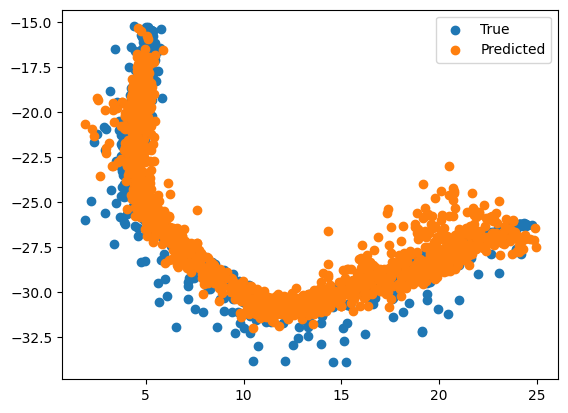

In [13]:
plt.scatter(y_train[:, 0], y_train[:, 1], label="True")
# pred = scaler.inverse_transform(pred)
pred = model.predict(x_train)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()

5/5 [==============================] - 0s 2ms/step


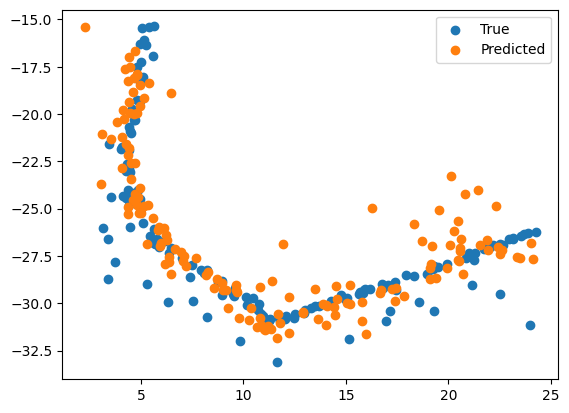

In [14]:
plt.scatter(y_test[:, 0], y_test[:, 1], label="True")
# pred = scaler.inverse_transform(pred)
pred = model.predict(x_test)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()

In [ ]:
mse_loss, mee_loss  = ELM.evaluate(x_train, y_train, verbose=0)
print(mse_loss)
print(mee_loss)